# Facial Landmark Segmentation
Segmentation of eyes and mouth on the Celeb Face Dataset.

## Extract dataset and install modules

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import cv2
import random
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from glob import glob
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, sampler
import albumentations as aug
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, Cutout, GaussNoise, RandomRotate90, Transpose, RandomBrightnessContrast, RandomCrop)
from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split

### Dataset Details
* 30,000 images
* Separate masks for left eye, right eye, upper lip, lower lip
* Additional details contain presence of sepctacles, narrow eyes etc.

### Basic Data Exploration
Run cell to see random image with eye and lip masks

In [ ]:
root = "./CelebAMask-HQ"
img_path = root+"/CelebA-HQ-img/"
mask_path = root+"/CelebAMask-HQ-mask-anno/"

files = glob(img_path+"*.jpg")
def get_mask(file, mask_path, image):
    '''
    Return mask of eyes plus lips for a given file
    :param file: path to image file (mask will have same name)
    :param mask_path: path to folder containing masks
    :return mask: the combined eyes and lips mask
    '''
    
    fname = file.split("/")[-1].split(".")[0]
    mask_fname = fname.zfill(5)
    mask_folder = str(int(fname)//2000)
    mask_files = glob(mask_path+"/"+mask_folder+"/"+mask_fname+"_l_lip.png")+\
        glob(mask_path+"/"+mask_folder+"/"+mask_fname+"_u_lip.png")+\
        glob(mask_path+"/"+mask_folder+"/"+mask_fname+"_l_eye.png")+\
        glob(mask_path+"/"+mask_folder+"/"+mask_fname+"_r_eye.png")
        #glob(mask_path+"/"+mask_folder+"/"+mask_fname+"_eye_g.png")
    print(mask_files)
    masks = [cv2.imread(i) for i in  mask_files]
    mask = masks[0]
    for i in range(1, len(masks)):
        mask = mask+masks[i]
           
    return mask

['./CelebAMask-HQ/CelebAMask-HQ-mask-anno//11/22405_l_lip.png', './CelebAMask-HQ/CelebAMask-HQ-mask-anno//11/22405_u_lip.png', './CelebAMask-HQ/CelebAMask-HQ-mask-anno//11/22405_l_eye.png', './CelebAMask-HQ/CelebAMask-HQ-mask-anno//11/22405_r_eye.png']


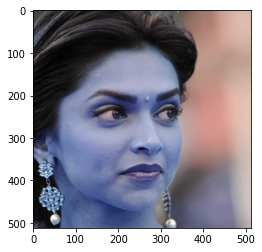

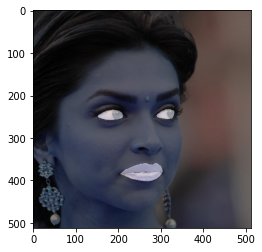

In [ ]:
idx = np.random.randint(len(files))
image = cv2.imread(files[idx])
image = cv2.resize(image, (512, 512))
mask = get_mask(files[idx], mask_path, image)
plt.imshow(image)
plt.show()
combined = cv2.addWeighted(image, 0.5, mask, beta=0.5, gamma=0.0)
plt.imshow(combined)
plt.show()

## Data Loader
Since we have different files for left eye, right eye, upper lip, lower lip, we assume a 4 class model. If the artefact is present, mask loaded as is. If not present, put zeros instead.

In [ ]:
class CelebData(Dataset):
    def __init__(self, phase, path="./CelebAMask-HQ"):
        self.transforms = get_transforms(phase)
        self.phase = phase
        self.path = path
        train_path = os.listdir(self.path+'/CelebA-HQ-img/')
        self.train = train_path

        self.dim = (256, 256)
        self.mask_dim = (256, 256)

    def __getitem__(self, idx):
        fname = self.train[idx].split(".")[0]
        mask_folder = str(int(fname)//2000)
        mask_name = fname.zfill(5)

        img = cv2.imread(self.path+'/CelebA-HQ-img/'+self.train[idx])
        img = cv2.resize(img, self.dim)
        
        mask = []
        l_eye = cv2.imread(self.path+'/CelebAMask-HQ-mask-anno/'+mask_folder+"/"+mask_name+"_l_eye.png", 0)
        if not l_eye is None:
            l_eye = cv2.resize(l_eye, self.dim)
            mask.append(l_eye)
        else:
            mask.append(np.zeros(self.mask_dim))

        r_eye = cv2.imread(self.path+'/CelebAMask-HQ-mask-anno/'+mask_folder+"/"+mask_name+"_r_eye.png", 0)
        if not r_eye is None:
            r_eye = cv2.resize(r_eye, self.dim)
            mask.append(r_eye)
        else:
            mask.append(np.zeros(self.mask_dim))
            
        l_lip = cv2.imread(self.path+'/CelebAMask-HQ-mask-anno/'+mask_folder+"/"+mask_name+"_l_lip.png", 0)
        if not l_lip is None:
            l_lip = cv2.resize(l_lip, self.dim)
            mask.append(l_lip)
        else:
            mask.append(np.zeros(self.mask_dim))

        u_lip = cv2.imread(self.path+'/CelebAMask-HQ-mask-anno/'+mask_folder+"/"+mask_name+"_u_lip.png", 0)
        if not u_lip is None:
            u_lip = cv2.resize(u_lip, self.dim)
            mask.append(u_lip)
        else:
            mask.append(np.zeros(self.mask_dim))  
        
        mask = np.asarray(mask) 
        mask = mask.astype(np.uint8)
        augmented = self.transforms(image=img, masks=mask)
        
        img = augmented['image']
        masks = augmented['masks']
        masks = np.asarray(masks)/255
        return img, masks

    def __len__(self):
        return len(self.train)

In [ ]:
def get_transforms(phase):
    list_transforms = []
    if phase == "train":
        list_transforms.extend([
            aug.RandomRotate90(),
            aug.ShiftScaleRotate(),
            aug.GaussNoise(),
            ])
        
    list_transforms.extend(
        [ToTensor()]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

### Check if dataloder works

In [ ]:
image_dataset = CelebData("train")
dataloader = DataLoader(train, batch_size=8, num_workers=0, pin_memory=False, shuffle=True)
for img, mask in dataloader:
    print(img.shape)
    print(mask.shape)
    print(mask[0].shape)
    break

torch.Size([8, 3, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([4, 256, 256])


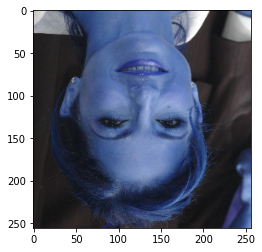

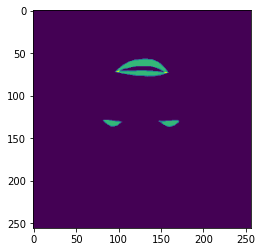

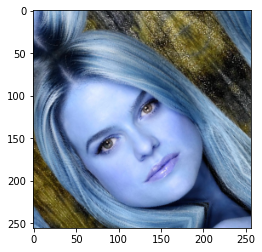

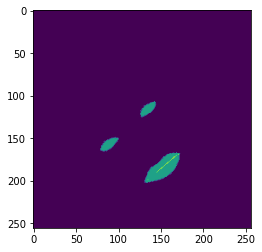

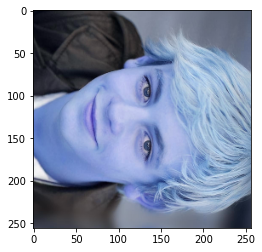

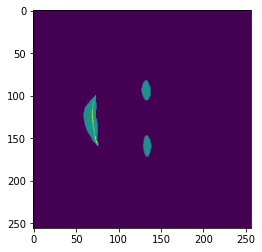

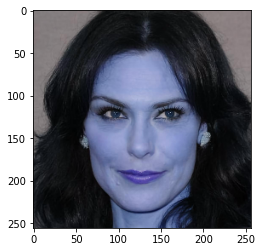

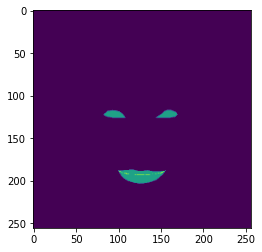

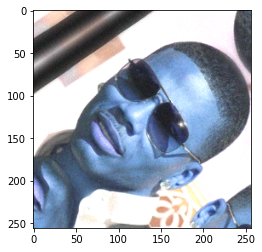

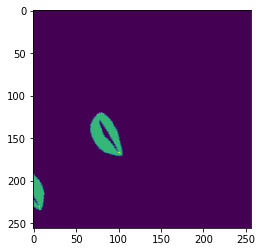

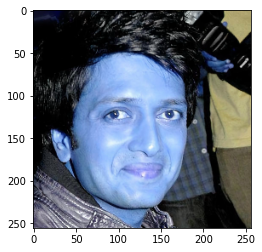

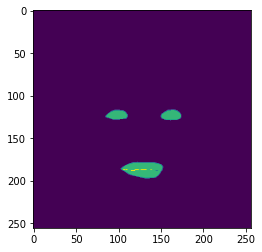

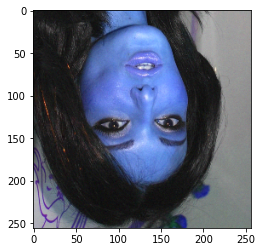

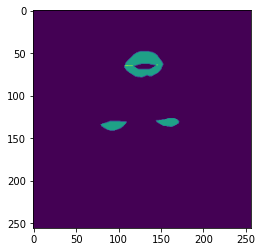

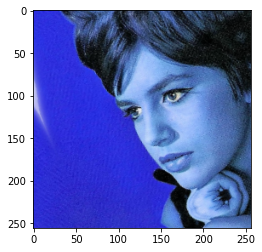

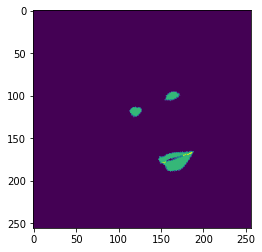

In [ ]:
for i in range(img.shape[0]):
    image = img[i].permute(1, 2, 0).cpu().numpy()
    msk = mask[i][0].squeeze().cpu().numpy() + mask[i][1].squeeze().cpu().numpy() + mask[i][2].squeeze().cpu().numpy() + mask[i][3].squeeze().cpu().numpy()
    plt.imshow(image)
    plt.show()
    plt.imshow(msk)
    plt.show()


## Combintion loss funciton 
Use BCE, Dice and Jaccard

In [ ]:
class BCEDiceJaccardLoss(nn.Module):
    __name__ = "Combined Loss"
    def __init__(self, eps=1e-7, beta=1., activation='sigmoid', ignore_channels=None, threshold=None):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.beta = beta
        self.eps = eps
        self.threshold = threshold
        self.ignore_channels = ignore_channels
        self.activation = smp.utils.base.Activation(activation)

    def forward(self, y_pr, y_gt):
        bce = self.bce(y_pr, y_gt)
        y_pr = self.activation(y_pr)
        dice = 1 - smp.utils.functional.f_score(
            y_pr, y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )
        jaccard = 1 - smp.utils.functional.jaccard(
            y_pr, y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )
        return (bce+dice+jaccard)/3

In [ ]:
model = smp.Unet("efficientnet-b4", encoder_weights='imagenet', classes=4, activation=None)
train_data = CelebData("train")
train, val, test = torch.utils.data.random_split(train_data, [int(0.7*len(train_data)), int(0.2*len(train_data)), int(0.1*len(train_data))])
del train_data
train_dataloader = DataLoader(train, batch_size=32, num_workers=0, pin_memory=False, shuffle=True)
valid_dataloader = DataLoader(val, batch_size=32, num_workers=0, pin_memory=False, shuffle=True)
loss = BCEDiceJaccardLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device="cuda",
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device="cuda",
    verbose=True,
)

## Train

In [ ]:
max_score = 0
epochs = 10
for i in range(0, epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dataloader)
    valid_logs = valid_epoch.run(valid_dataloader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    torch.save(model, './last_model.pth')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 188/188 [03:40<00:00,  1.17s/it, Combined Loss - 0.5769, iou_score - 0.6115]
Model saved!

Epoch: 1
valid: 100%|██████████| 188/188 [03:20<00:00,  1.06s/it, Combined Loss - 0.151, iou_score - 0.7654]
Model saved!

Epoch: 2
valid: 100%|██████████| 188/188 [03:23<00:00,  1.08s/it, Combined Loss - 0.129, iou_score - 0.773]
Model saved!

Epoch: 3
valid: 100%|██████████| 188/188 [03:19<00:00,  1.06s/it, Combined Loss - 0.1199, iou_score - 0.7831]
Model saved!

Epoch: 4
valid: 100%|██████████| 188/188 [03:18<00:00,  1.06s/it, Combined Loss - 0.1162, iou_score - 0.7875]
Model saved!

Epoch: 5
valid: 100%|██████████| 188/188 [03:17<00:00,  1.05s/it, Combined Loss - 0.1145, iou_score - 0.7901]
Model saved!

Epoch: 6
valid: 100%|██████████| 188/188 [03:22<00:00,  1.08s/it, Combined Loss - 0.1128, iou_score - 0.7908]
Model saved!

Epoch: 7
valid: 100%|██████████| 188/188 [03:20<00:00,  1.07s/it, Combined Loss - 0.1117, iou_score - 0.7928]
Model saved!

Epoch: 8
v

## Test

In [ ]:
test_dataloader = DataLoader(test, batch_size=32, num_workers=0, pin_memory=False, shuffle=True)
dice_sum = 0
jaccard_sum = 0
num_imgs = 0
with torch.no_grad():
    for imgs, y_gt in test_dataloader:
        y_gt = y_gt.type("torch.cuda.FloatTensor")
        y_pr = model(imgs.type("torch.cuda.FloatTensor"))
        y_pr = nn.Sigmoid()(y_pr)
        dice = smp.utils.functional.f_score(
                y_pr, y_gt,
                beta=1,
                eps=1e-7,
                threshold=None,
                ignore_channels=None,
            )
        jaccard = smp.utils.functional.jaccard(y_pr, y_gt)
        jaccard_sum += jaccard
        dice_sum += dice
        num_imgs += 1
print("Test Dice Score: ", dice_sum/num_imgs)
print("Test Jaccard Score: ", jaccard_sum/num_imgs)        

Test Dice Score:  tensor(0.8842, device='cuda:0')
Test Jaccard Score:  tensor(0.7925, device='cuda:0')


## Prediction and Ploting

In [ ]:
def plot(img, model, thresh):
    image = img
    augmented = get_transforms('test')(image = img)
    img = augmented['image']
    img = img.unsqueeze(0)
    y_preds = model(img.type('torch.cuda.FloatTensor'))
    y_preds = nn.Sigmoid()(y_preds)
    y_preds = y_preds.squeeze().detach().cpu().numpy()
    
    y_preds = (y_preds > thresh).astype('uint8')*255
    res = y_preds[0]+y_preds[1]+y_preds[2]+y_preds[3]
    res = np.asarray([res, res, res]).astype(np.uint8)
    res = np.moveaxis(res, 0, -1)
    combined = cv2.addWeighted(image, 0.5, res, beta=0.5, gamma=0.0)
    plt.figure()
    plt.imshow(image)
    plt.figure()
    plt.imshow(combined)    
    plt.show()
    
def predict(model_path, img_path = None, thresh = 0.8):
    checkpoint = torch.load(model_path)
    shape = (256, 256)          
    img = cv2.imread(img_path)
    img = cv2.resize(img, shape, interpolation = cv2.INTER_NEAREST)
    plot(img, model, thresh)

0


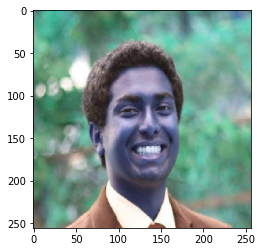

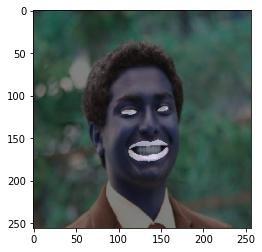

In [ ]:
#files = glob("./CelebAMask-HQ/CelebA-HQ-img/*.jpg")
files = glob("./*.jpg")
idx = np.random.randint(len(files))
print(idx)
predict("./best_model.pth", files[idx])